# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import time
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Positive and Negative points 

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:36<00:00, 2412.10it/s]


In [24]:
preprocessed_reviews[1500]

'love lady finger popcorn much flavor million times better microwave popcorn thousand times better popcorn super market warning good stuff never want eat regular popcorn'

# Taking  14k  Sample  of positive data  and 14k negative data points

In [24]:
#replacing the reviews with preprocessed reviews 
final['Text']=preprocessed_reviews 


positive = final[final["Score"] == 1].sample(n = 14000)
negative = final[final["Score"] == 0].sample(n = 14000)
final_posinegi = pd.concat([positive, negative])
final_posinegi.shape

(28000, 10)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 87773/87773 [00:22<00:00, 3835.60it/s]


In [26]:
#comparing the original summary vs preprocessed summary
print(final.Summary[:10])
print('='*50)
print(preprocessed_summary[:10])

22620                              made in china
22621                          Dog Lover Delites
70677                    only one fruitfly stuck
70676    Doesn't work!! Don't waste your money!!
70675                              A big rip off
70673     THIS ITEM IS EXCELLENT TO KILL INSECTS
70672                                Didn't work
70671                        Gross but effective
70670                        Didn't work for me.
70669                             Waste of money
Name: Summary, dtype: object
['made china', 'dog lover delites', 'one fruitfly stuck', 'not work not waste money', 'big rip', 'item excellent kill insects', 'not work', 'gross effective', 'not work', 'waste money']


In [27]:
#replacing final.summary with preprocessed summary
final.Summary = preprocessed_summary
final.Summary[:10]

22620                     made china
22621              dog lover delites
70677             one fruitfly stuck
70676       not work not waste money
70675                        big rip
70673    item excellent kill insects
70672                       not work
70671                gross effective
70670                       not work
70669                    waste money
Name: Summary, dtype: object

In [28]:
fd = final_posinegi

In [29]:
# Sorting based on time
fd['Time'] = pd.to_datetime(fd['Time'], origin='unix', unit='s')
fd= fd.sort_values('Time')
fd.shape

(28000, 10)

In [30]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

Before Vectorization
Train---> (18760,) (18760,)
Test----> (9240,) (9240,)


# [4] Featurization

## [4.1] BAG OF WORDS

### for brute force 

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max)
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(18760, 26831) (18760,)
(9240, 26831) (9240,)


### for kdtree

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(max_features=500, min_df=10)
vectorizer2.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow_kd = vectorizer2.transform(X_train)
X_test_bow_kd = vectorizer2.transform(X_test)

print("After vectorizations")
print(X_train_bow_kd.shape, y_train.shape)
print(X_test_bow_kd.shape, y_test.shape)

print("Type")
print(type(X_train_bow_kd))
print(type(X_test_bow_kd))

print('='*50)

print("Type after making it dense matrix")
X_train_bow_kd = X_train_bow_kd.toarray()
X_test_bow_kd = X_test_bow_kd.toarray()
print(type(X_train_bow_kd))
print(type(X_test_bow_kd))

After vectorizations
(18760, 500) (18760,)
(9240, 500) (9240,)
Type
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
Type after making it dense matrix
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## [4.2] Bi-Grams and n-Grams.

In [33]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

In [34]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (18760, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

### for brute force

In [35]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

Before Vectorization
Train---> (18760,) (18760,)
Test----> (9240,) (9240,)


In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10)
tf_idf_vect.fit(X_train)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(18760, 11630) (18760,)
(9240, 11630) (9240,)


### for kd tree

In [37]:
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features=500)
tf_idf_vect2.fit(X_train)

X_train_tfidf_kd = tf_idf_vect2.transform(X_train)
X_test_tfidf_kd = tf_idf_vect2.transform(X_test)

print("After vectorizations")
print(X_train_tfidf_kd.shape, y_train.shape)
print(X_test_tfidf_kd.shape, y_test.shape)

print("Type")
print(type(X_train_tfidf_kd))
print(type(X_test_tfidf_kd))

print('='*50)

print("Type after making it dense matrix")
X_train_tfidf_kd = X_train_tfidf_kd.toarray()
X_test_tfidf_kd = X_test_tfidf_kd.toarray()
print(type(X_train_tfidf_kd))
print(type(X_test_tfidf_kd))

After vectorizations
(18760, 500) (18760,)
(9240, 500) (9240,)
Type
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
Type after making it dense matrix
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## [4.4] Word2Vec

In [38]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False) 
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)

Train Data (18760,) (18760,)
Test Data (9240,) (9240,)


In [39]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [40]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8635
sample words  ['contamination', 'marshmallow', 'barbecue', 'carrageenan', 'crunchies', 'nutshell', 'registered', 'bug', 'corned', 'fattening', 'icicle', 'prepare', 'babies', 'refried', 'less', 'background', 'jumps', 'infusion', 'taped', 'suck', 'dietary', 'lemonade', 'lasagna', 'feeding', 'kibbles', 'passable', 'cools', 'blackberry', 'sunset', 'ingest', 'mistakenly', 'unhealthy', 'fondue', 'licked', 'wolfed', 'hearty', 'points', 'please', 'freezer', 'thinly', 'sticks', 'sum', 'currants', 'iam', 'prototype', 'matters', 'canned', 'six', 'reserve', 'brulee']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

##### Converting train data

In [41]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

In [42]:
from tqdm import tqdm
import numpy as np
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [43]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 18760/18760 [01:28<00:00, 211.65it/s]

(18760, 50)
[-0.11519913 -0.19077421  0.0200234  -0.10134375  0.28104697 -0.02214279
 -0.43752698  0.11049712  0.03106715 -0.58219283  0.27773945  0.0434515
  0.14087883  0.60492643  0.37394283  0.17622982  0.21521404  0.01391303
  0.1700987   0.5384064  -0.20496482  0.44887029 -0.06875973  0.71130695
  0.38100965 -0.22804092  0.05366251  0.25645151 -0.07526254  0.36565514
 -0.13403163  0.04698805  0.15001356  0.05144045  0.01515091 -0.05732524
  0.26627972  0.04771955  0.00554328 -0.45030324 -0.2929952   0.21118745
 -0.1248952  -0.42958669  0.33531827 -0.16076484  0.1485561   0.24124493
  0.22541111  1.0615457 ]


##### Converting test data

In [44]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [45]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 9240/9240 [00:44<00:00, 208.71it/s]

(9240, 50)
[-0.19373355 -0.63582069  0.1363659   0.05289196  0.3832749   0.38314858
 -0.61462094 -0.28261552 -0.87331942 -0.74537855  1.23185772  0.36601212
  0.33053832  0.81034146  0.33234372 -0.30279437  0.04812229 -0.01503141
  0.42684871  0.90257574 -0.71046178  0.91762203 -0.7486604   0.93294935
  1.18900002 -0.08174015  0.13824645  0.02607103 -0.07928999  0.28084229
 -0.47873239 -0.81047915 -0.54661783  0.00184287  0.88313825 -0.2862976
 -0.48024906  0.0129047   0.15420831  0.04272267 -0.0975178  -0.22794421
 -0.44338686  0.03545643  0.81767983 -0.41341758 -0.29142789  0.64391212
  0.4875642   1.20879825]


#### [4.4.1.2] TFIDF weighted W2v

In [46]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)

Train Data (18760,) (18760,)
Test Data (9240,) (9240,)


In [47]:
model1 = TfidfVectorizer()
tf_idf_train_w2v= model1.fit_transform(X_train)
tf_idf_test_w2v= model1.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(model1.get_feature_names(), list(model1.idf_)))
print(tf_idf_train_w2v.shape, tf_idf_test_w2v.shape)

(18760, 26831) (9240, 26831)


##### Converting train data

In [48]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat_train = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_train:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

100%|██████████| 18760/18760 [05:11<00:00, 60.24it/s]


##### Converting test data

In [50]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [51]:
# TF-IDF weighted Word2Vec
tfidf_feat_test = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_test:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

100%|██████████| 9240/9240 [02:35<00:00, 59.54it/s]


In [52]:
print(tfidf_sent_vectors_train.shape,tfidf_sent_vectors_test.shape)

(18760, 50) (9240, 50)


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### KNN with brute force function using GridSearch

In [53]:
def knn_brute_force(Xtrain,ytrain):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    K = [9,15,27,35,43,59,73,89,93]#using odd numbers for K in knn
    neigh = KNeighborsClassifier(algorithm = "brute")
    parameters = {'n_neighbors':K}
    clf = GridSearchCV(neigh, parameters, cv=4, scoring='roc_auc',return_train_score=True)
    clf.fit(Xtrain, ytrain)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    best_k= clf.best_params_
    best_k = list(best_k.values())[0]

    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')
    plt.grid(True)
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return best_k

### Function for picking the best threshold that will give the least fpr

In [54]:
# we are writing our own function for predict, with defined thresholds
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


### Function for confusion matrix with best threshold values

In [55]:
def conf_matrix(Xtrain,ytrain,Xtest,ytest,best_t):
    #https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels 
    y_train_pred = neigh_bow.predict_proba(Xtrain)[:,1]  
    y_test_pred = neigh_bow.predict_proba(Xtest)[:,1]
    from sklearn.metrics import confusion_matrix
    print('Train Data')
    cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
    cl = ['Negative', 'Positive']
    confusion_df = pd.DataFrame(cm, index=cl, columns=cl)
    sns.heatmap(confusion_df, annot=True, fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print('='*50)
    print('Test Data')
    cm_test= (confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
    confusion_df_test = pd.DataFrame(cm_test, index=cl, columns=cl)
    sns.heatmap(confusion_df_test, annot=True, fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

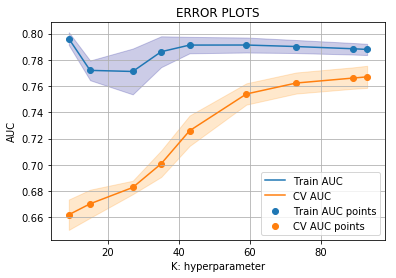

Best K is : 93
Wall time: 7min 7s


In [56]:
%%time
best_bow_K = knn_brute_force(X_train_bow,y_train)
print('Best K is :', best_bow_K)

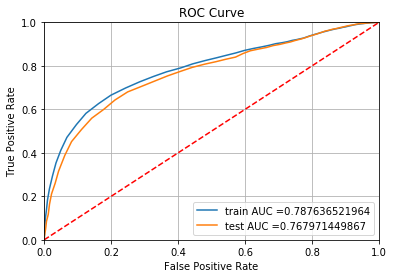

In [57]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

neigh_bow = KNeighborsClassifier(n_neighbors=best_bow_K, algorithm = "brute")
neigh_bow.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_bow.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_bow.predict_proba(X_test_bow)[:,1])

plt.grid(True)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.532534584878 for threshold 0.602
Train Data


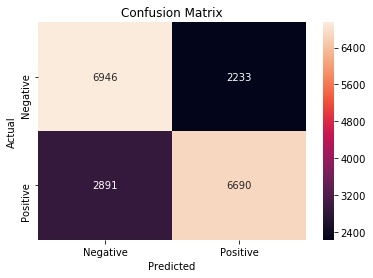

Test Data


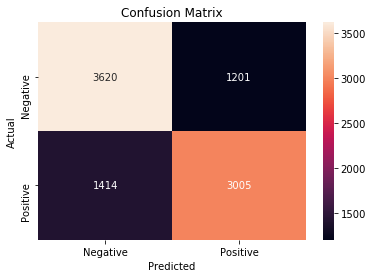

In [58]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

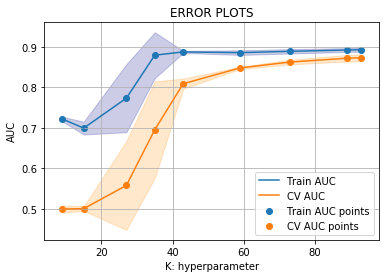

Best K is : 93
Wall time: 7min 17s


In [59]:
%%time
best_tfidf_K = knn_brute_force(X_train_tfidf,y_train)
print('Best K is :', best_tfidf_K)

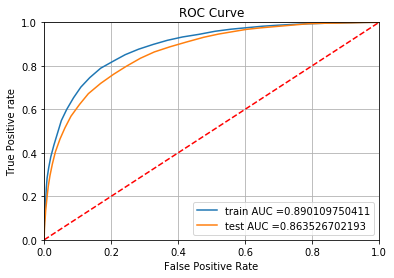

In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

neigh_tfidf = KNeighborsClassifier(n_neighbors=best_tfidf_K,algorithm = "brute")
neigh_tfidf.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_tfidf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_tfidf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


the maximum value of tpr*(1-fpr) 0.656076499319 for threshold 0.559
Train Data


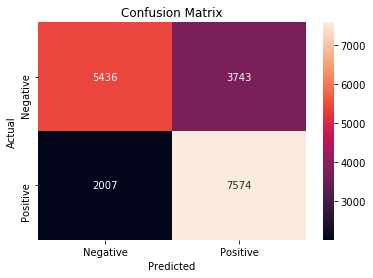

Test Data


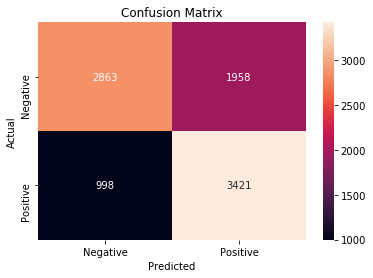

In [61]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

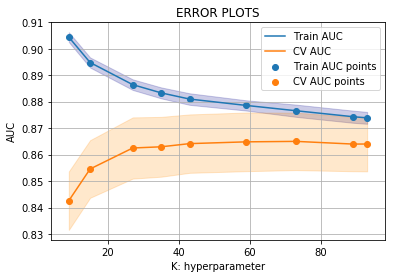

Best K is : 73
Wall time: 4min 30s


In [62]:
%%time
best_avgw2v_K = knn_brute_force(sent_vectors_train,y_train)
print('Best K is :', best_avgw2v_K)

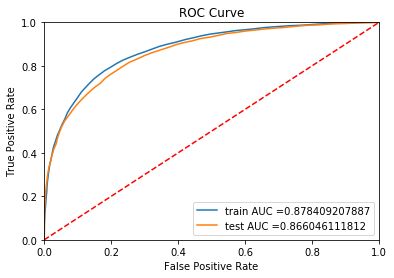

In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

neigh_avgw2v = KNeighborsClassifier(n_neighbors=best_avgw2v_K,algorithm = "brute")
neigh_avgw2v.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_avgw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_avgw2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.637295900088 for threshold 0.507
Train Data


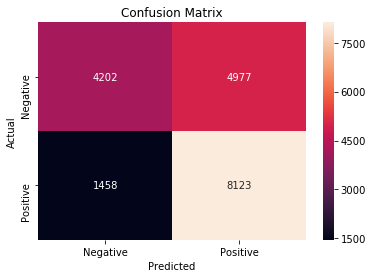

Test Data


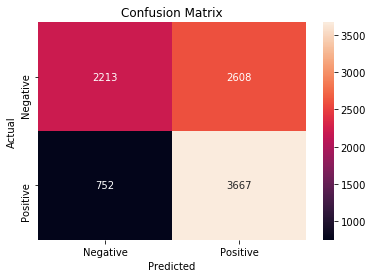

In [64]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

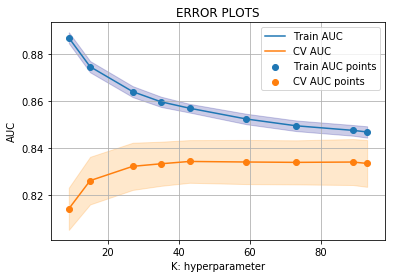

Best K is : 43
Wall time: 4min 32s


In [65]:
%%time
best_tfidfw2v_K = knn_brute_force(tfidf_sent_vectors_train,y_train)
print('Best K is :', best_tfidfw2v_K)

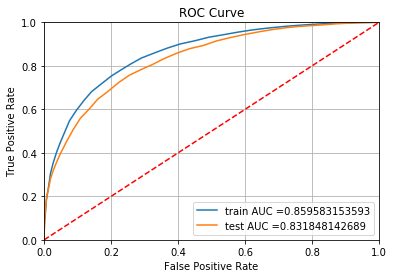

In [66]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

neigh_tfidfw2v = KNeighborsClassifier(n_neighbors=best_tfidfw2v_K,algorithm='brute')
neigh_tfidfw2v.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_tfidfw2v.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_tfidfw2v.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.602160188326 for threshold 0.512
Train Data


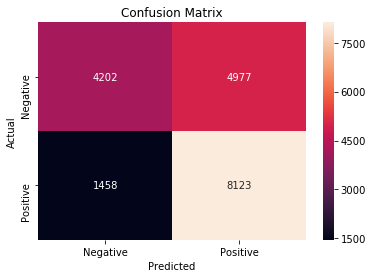

Test Data


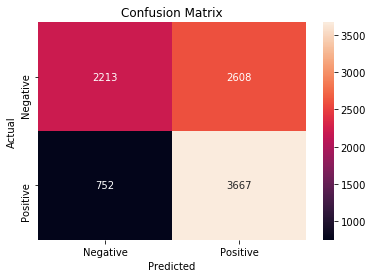

In [67]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

## [5.2] Applying KNN kd-tree

### KNN with kdtree function using GridSearch

In [85]:
def knn_kdtree(Xtrain,ytrain):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    from sklearn.model_selection import GridSearchCV
    from sklearn.neighbors import KNeighborsClassifier
    import matplotlib.pyplot as plt
    K = [9,15,27,35,43,59,73,89,93]
    neigh = KNeighborsClassifier(algorithm = "kd_tree")
    parameters = {'n_neighbors':K}
    clf = GridSearchCV(neigh, parameters, cv=4, scoring='roc_auc',return_train_score=True)
    clf.fit(Xtrain, ytrain)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    best_k_kd= clf.best_params_
    best_k_kd= list(best_k_kd.values())[0]


    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')
    plt.grid(True)
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return best_k_kd
        
    


### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

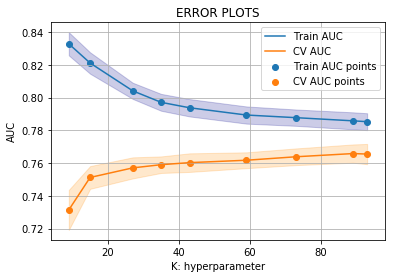

Best K is : 89
Wall time: 2h 44min 2s


In [86]:
%%time
best_bow_K_kd = knn_kdtree(X_train_bow_kd,y_train)
print('Best K is :', best_bow_K_kd)

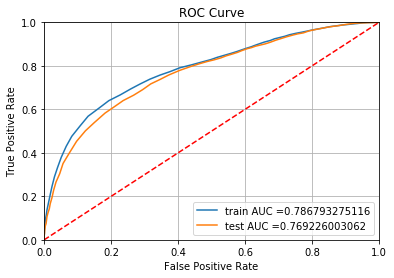

In [87]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
neigh_bow_kd = KNeighborsClassifier(n_neighbors=best_bow_K_kd,algorithm = 'kd_tree')
neigh_bow_kd.fit(X_train_bow_kd, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_bow_kd.predict_proba(X_train_bow_kd)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_bow_kd.predict_proba(X_test_bow_kd)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.516377666656 for threshold 0.551
Train Data


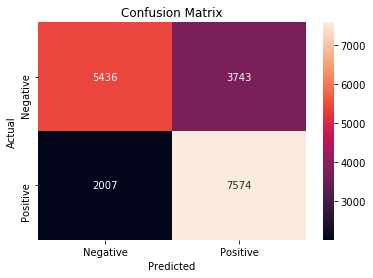

Test Data


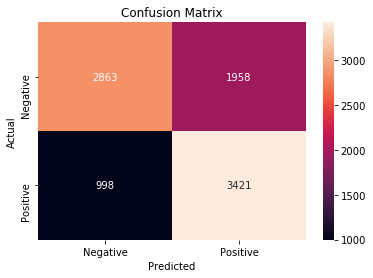

In [88]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

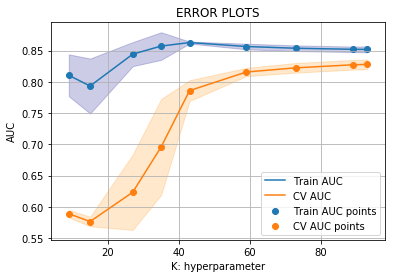

Best K is : 93
Wall time: 2h 36min 38s


In [89]:
%%time
best_tfidf_K_kd = knn_kdtree(X_train_tfidf_kd,y_train)
print('Best K is :', best_tfidf_K_kd)

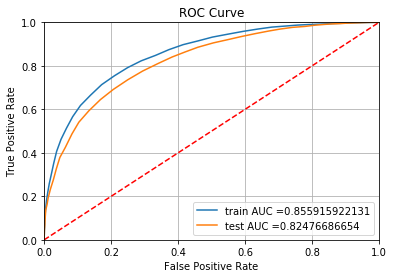

In [90]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
neigh_tfidf_kd = KNeighborsClassifier(n_neighbors=best_tfidf_K_kd,algorithm = 'kd_tree')
neigh_tfidf_kd.fit(X_train_tfidf_kd, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_tfidf_kd.predict_proba(X_train_tfidf_kd)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_tfidf_kd.predict_proba(X_test_tfidf_kd)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.596115352908 for threshold 0.559
Train Data


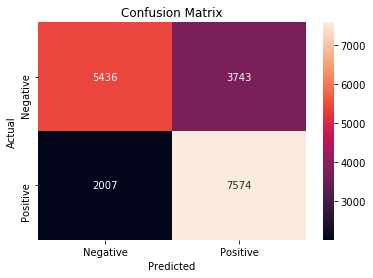

Test Data


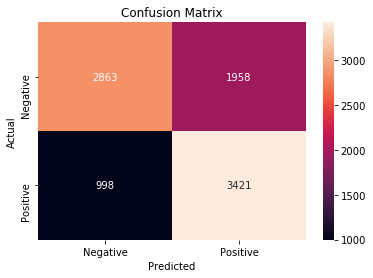

In [91]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

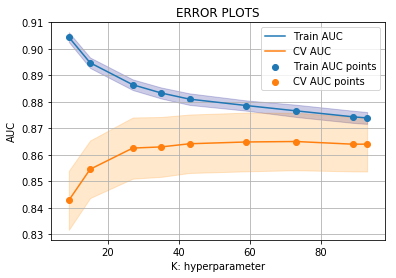

Best K is : 73
Wall time: 18min 26s


In [92]:
%%time
best_avgw2v_K_kd = knn_kdtree(sent_vectors_train,y_train)
print('Best K is :', best_avgw2v_K_kd)

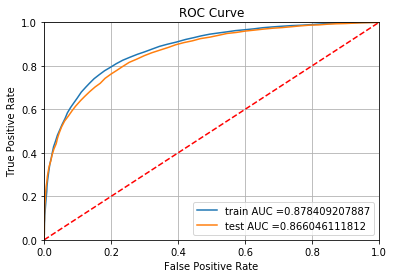

In [93]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
neigh_avgw2v_kd = KNeighborsClassifier(n_neighbors=best_avgw2v_K_kd,algorithm = 'kd_tree')
neigh_avgw2v_kd.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_avgw2v_kd.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_avgw2v_kd.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.637295900088 for threshold 0.507
Train Data


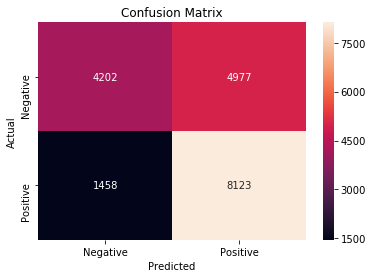

Test Data


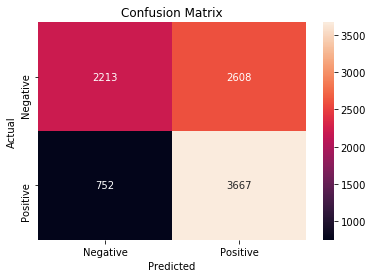

In [94]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

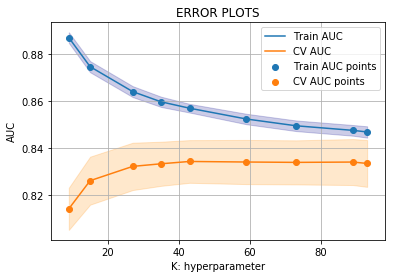

Best K is : 43
Wall time: 16min 21s


In [95]:
%%time
best_tfidfw2v_K_kd = knn_kdtree(tfidf_sent_vectors_train,y_train)
print('Best K is :', best_tfidfw2v_K_kd)

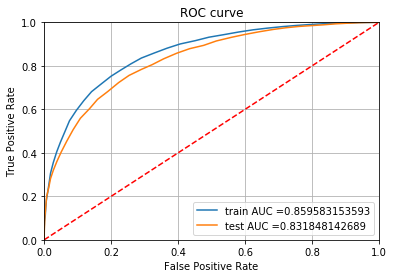

In [96]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
neigh_tfidfw2v_kd = KNeighborsClassifier(n_neighbors=best_tfidfw2v_K_kd,algorithm = 'kd_tree')
neigh_tfidfw2v_kd.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh_tfidfw2v_kd.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh_tfidfw2v_kd.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.grid()
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.602160188326 for threshold 0.512
Train Data


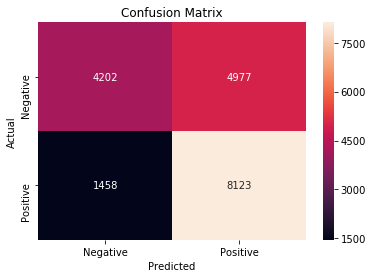

Test Data


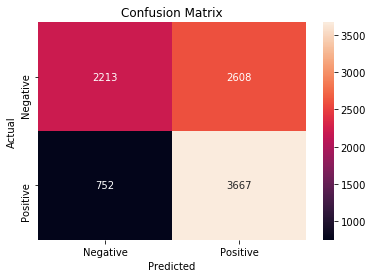

In [97]:
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t)

# [6] Conclusions

In [99]:
# Creating table using PrettyTable library
from prettytable import PrettyTable
vectorizer = ['BOW','TFIDF','AvgW2v','TFIDFw2v','BOW','TFIDF','AvgW2v','TFIDFw2v']
AUC = [0.76,0.89,0.86,0.83,0.76,0.82,0.86,0.83]
Model = ['Brute','Brute','Brute','Brute','KD Tree','KD Tree','KD Tree','KD Tree']
hyperparameter = [93,93,73,43,89,93,73,43]
sno = [1,2,3,4,5,6,7,8]
# Initializing prettytable
ptable = PrettyTable()
# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("     Vectorizer            ",vectorizer)
ptable.add_column("      Model          ",Model)
ptable.add_column("Hyperparameter    ",hyperparameter)
ptable.add_column("  Test AUC              ",AUC)
# Printing the Table
print(ptable)

+-------+-----------------------------+-----------------------+--------------------+--------------------------+
| S.NO. |      Vectorizer             |       Model           | Hyperparameter     |   Test AUC               |
+-------+-----------------------------+-----------------------+--------------------+--------------------------+
|   1   |             BOW             |         Brute         |         93         |           0.76           |
|   2   |            TFIDF            |         Brute         |         93         |           0.89           |
|   3   |            AvgW2v           |         Brute         |         73         |           0.86           |
|   4   |           TFIDFw2v          |         Brute         |         43         |           0.83           |
|   5   |             BOW             |        KD Tree        |         89         |           0.76           |
|   6   |            TFIDF            |        KD Tree        |         93         |           0.82     

In [102]:
!jupyter nbconvert --to html affr_knn_final.ipynb

[NbConvertApp] Converting notebook affr_knn_final.ipynb to html
[NbConvertApp] Writing 1220487 bytes to affr_knn_final.html
